In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, re, datetime
import itertools
import category_encoders
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
allegro_transactions = pd.read_csv('allegro-api-transactions.csv')
allegro_transactions.date = allegro_transactions.date.apply(lambda str_date_time : datetime.datetime.strptime(str_date_time, '%Y-%m-%d %H:%M:%S'))
allegro_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
lp                        420020 non-null int64
date                      420020 non-null datetime64[ns]
item_id                   420020 non-null int64
categories                420020 non-null object
pay_option_on_delivery    420020 non-null int64
pay_option_transfer       420020 non-null int64
seller                    420020 non-null object
price                     420020 non-null float64
it_is_allegro_standard    420020 non-null int64
it_quantity               420020 non-null int64
it_is_brand_zone          420020 non-null int64
it_seller_rating          420020 non-null int64
it_location               420020 non-null object
main_category             420020 non-null object
dtypes: datetime64[ns](1), float64(1), int64(8), object(4)
memory usage: 44.9+ MB


# zmienne kategoryczne w zbiorze Allegro

* item_id
* categories - zmienna nieatomowa, ale można wykonać word2vec
* seller
* it_location
* main_category

W poniższym przeglądzie metod *category encodingu* będę zajmował się kodowanie zmiennej **main_category**. Ma relatywnie dużą liczbę unikalnych poziomów i jest interpretowalna w przeciwieństwie do item_id czy też nazwy sprzedawcy.

# Specyfikacja problemu klasyfikacji

Podczas przeglądu sposobów kodowania wielopoziomowych zmiennych jakościowych będę zajmował się problemem przewidywania wartości zmiennej **it_is_allegro_standard**. Jest to jedyna zmienna, która może zostać nadana z zewnątrz - serwis Allegro może w ten sposób oznaczać produkty/sprzedawców godnych zaufania.

## wybór zmiennych predykcyjnych do modelu

* pay_option_on_delivery
* pay_option_transfer
* price
* it_quantity
* it_is_brand_zone
* main_category

In [3]:
X, y = allegro_transactions.loc[:,['pay_option_on_delivery',
                     'pay_option_transfer',
                     'price',
                     'it_quantity',
                     'it_is_brand_zone',
                     'it_seller_rating',
                     'main_category']], allegro_transactions.loc[:,'it_is_allegro_standard']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(f'Liczba kategorii w zbiorze treningowym: {X_train.main_category.unique().size}')
print(f'Liczba kategorii w zbiorze testowym: {X_test.main_category.unique().size}')

Liczba kategorii w zbiorze treningowym: 26
Liczba kategorii w zbiorze testowym: 27


# Więcej kategorii w zbiorze testowym, niż w treningowym

## Naive OneHotEncoding - zakończy się błędem z powodu nieznanych poziomów

In [5]:
ce = category_encoders.OneHotEncoder(use_cat_names=True, handle_unknown='error')
rfc = RandomForestClassifier(n_estimators=15, max_depth=15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

AUC zbioru treningowego: 0.7430784458409457


ValueError: Unexpected categories found in column main_category

## OneHotEncoding ignoring unknown category

In [6]:
ce = category_encoders.OneHotEncoder(use_cat_names=True, handle_unknown='ignore')
rfc = RandomForestClassifier(n_estimators = 15, max_depth = 15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

ce.fit_transform(X_train).head()

AUC zbioru treningowego: 0.7430784458409457
AUC zbioru testowego: 0.7301077119035775


,main_category_Dom i Ogród,main_category_RTV i AGD,main_category_Zdrowie,main_category_Dla Dzieci,main_category_Motoryzacja,main_category_Telefony i Akcesoria,main_category_Kolekcje,main_category_Sport i Turystyka,main_category_Książki i Komiksy,"main_category_Odzież, Obuwie, Dodatki",...,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Filmy,main_category_Instrumenty,main_category_Bilety,pay_option_on_delivery,pay_option_transfer,price,it_quantity,it_is_brand_zone,it_seller_rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,10.49,2520,0,7909
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,185.00,8,0,5114
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,20.00,14,0,17696
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,34.10,195,0,37764
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,29.20,998,0,10631


## OneHotEncoding imputing unknown category

In [7]:
ce = category_encoders.OneHotEncoder(use_cat_names=True, handle_unknown='impute')
rfc = RandomForestClassifier(n_estimators = 15, max_depth = 15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

ce.fit_transform(X_train).head()

AUC zbioru treningowego: 0.7530716509893248
AUC zbioru testowego: 0.7384287839027365


,main_category_Dom i Ogród,main_category_RTV i AGD,main_category_Zdrowie,main_category_Dla Dzieci,main_category_Motoryzacja,main_category_Telefony i Akcesoria,main_category_Kolekcje,main_category_Sport i Turystyka,main_category_Książki i Komiksy,"main_category_Odzież, Obuwie, Dodatki",...,main_category_Filmy,main_category_Instrumenty,main_category_Bilety,main_category_-1,pay_option_on_delivery,pay_option_transfer,price,it_quantity,it_is_brand_zone,it_seller_rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,10.49,2520,0,7909
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,185.00,8,0,5114
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,20.00,14,0,17696
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,34.10,195,0,37764
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,29.20,998,0,10631


## Ordinal encoding imputing unknown category

In [8]:
ce = category_encoders.OrdinalEncoder(handle_unknown='impute')
rfc = RandomForestClassifier(n_estimators = 15, max_depth = 15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

ce.fit_transform(X_train).head()

AUC zbioru treningowego: 0.7751545528729218
AUC zbioru testowego: 0.7518715433045855


,pay_option_on_delivery,pay_option_transfer,price,it_quantity,it_is_brand_zone,it_seller_rating,main_category
0,1,0,10.49,2520,0,7909,1
1,1,1,185.00,8,0,5114,1
2,1,1,20.00,14,0,17696,2
3,1,1,34.10,195,0,37764,1
4,1,1,29.20,998,0,10631,3


## Binary encoding imputing unknown category

In [11]:
ce = category_encoders.BinaryEncoder(handle_unknown='impute')
rfc = RandomForestClassifier(n_estimators = 15, max_depth = 15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

ce.fit_transform(X_train).head()

AUC zbioru treningowego: 0.7860779589700553
AUC zbioru testowego: 0.7615252432915729


,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,pay_option_on_delivery,pay_option_transfer,price,it_quantity,it_is_brand_zone,it_seller_rating
0,0,0,0,0,0,1,1,0,10.49,2520,0,7909
1,0,0,0,0,0,1,1,1,185.00,8,0,5114
2,0,0,0,0,1,0,1,1,20.00,14,0,17696
3,0,0,0,0,0,1,1,1,34.10,195,0,37764
4,0,0,0,0,1,1,1,1,29.20,998,0,10631


## Target encoding imputing unknown category

In [9]:
ce = category_encoders.TargetEncoder()
rfc = RandomForestClassifier(n_estimators = 15, max_depth = 15, random_state=42)

steps = [('ce', ce),
         ('rfc', rfc)]

pipeline = Pipeline(steps)


pipeline.fit(X_train, y_train)

print(f'AUC zbioru treningowego: {roc_auc_score(y_train, pipeline.predict(X_train))}')
print(f'AUC zbioru testowego: {roc_auc_score(y_test, pipeline.predict(X_test))}')

ce.fit_transform(X_train, y_train).head()

AUC zbioru treningowego: 0.7808447144173458
AUC zbioru testowego: 0.7572310343216038


,pay_option_on_delivery,pay_option_transfer,price,it_quantity,it_is_brand_zone,it_seller_rating,main_category
0,1,0,10.49,2520,0,7909,0.595935
1,1,1,185.00,8,0,5114,0.595935
2,1,1,20.00,14,0,17696,0.652341
3,1,1,34.10,195,0,37764,0.595935
4,1,1,29.20,998,0,10631,0.622058


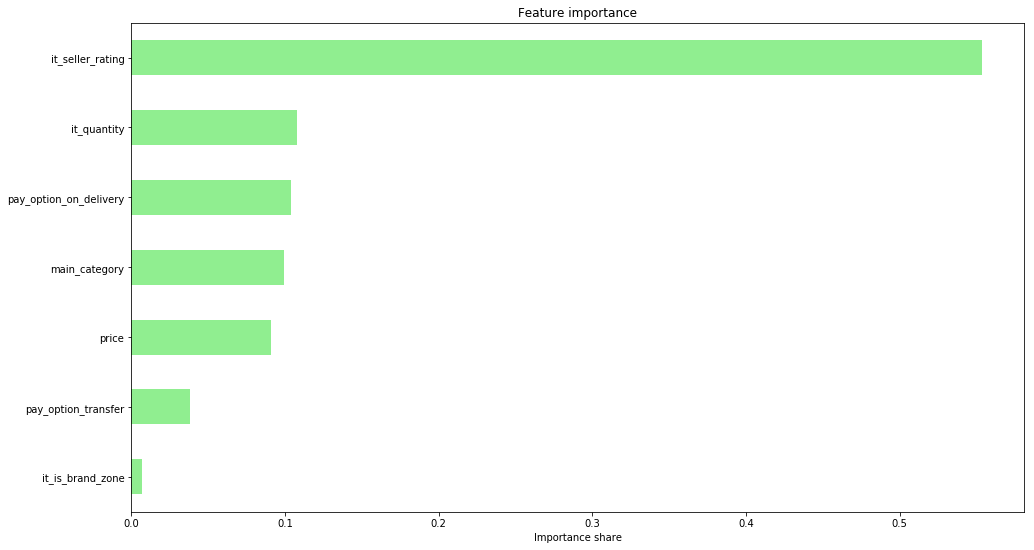

In [10]:
plt.figure(figsize=(16,9))
pd.Series(pipeline.get_params()['steps'][1][1].feature_importances_, index=ce.fit_transform(X_train, y_train).columns).sort_values().plot(kind='barh',color='lightgreen')
plt.title('Feature importance')
plt.xlabel('Importance share')
plt.show()

# Wnioski

Na powyższym wykresie widzimy, że w przypadku przewidywania it_is_allegro_standard zmiana kodowowania zmiennej main_category ma niewielki, chociaż zauważalny wpływ na wynik decyzji w lesie losowym. Dlatego też podczas wyboru różnych category encoderów warto zwrócić uwagę na poniższe aspekty:

* **model complexity** - One Hot Encoding: najwięcej zmiennych - największe model complexity, Ordinal Encoding: nie zwiększa liczby zmiennych, chociaż przypisane wartości numeryczne nie mają znaczenia ilościowego, co powoduje zwiększony bias (niedopasowanie) modelu. Binary Encoding: w celu odczytania kategorii trzeba przetworzyć bity zawrte we **wszystkich** nowych kolumach - nie zwiększa model complexity tak jak One Hot Encoding, ale tworzy silnie zależne od siebie kolumny. Target Encoding: nie zwiększa liczby zmiennych, a przypisane wartości numeryczne związane są z faktyczną korelacją kategorii z przewidywaną zmienną.
* **model explainability** - ze wszystkich metod, tylko target encoding pozwala na powiązanie wpływu występowania danej kategorii z przewidywaną wartością zmiennej it_is_allegro_standard. W przypadku bardziej skomplikowanych modeli może przynieść to znaczną wartość, nawet jeżeli nie wykorzystamy wartości po target encoding